# Convolutional Clasification of Dreams

In [2]:
# Include usual stuff.
import torch as th
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as td
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from os import mkdir
from shutil import copyfile, copytree
import torch
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import sys
import torch as th
import fastai
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.optimizer import OptimWrapper
from torch import optim

from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.callback.progress import ProgressCallback
from fastai.callback.data import CudaCallback

In [42]:
# normalize = transforms.Normalize((0.52,), (0.34,))

TRANF_POWER = 0.1

train_transform = transforms.Compose([
        # transforms.Grayscale(),
        # transforms.ColorJitter(2 * TRANF_POWER, 2 * TRANF_POWER, TRANF_POWER, TRANF_POWER),
        transforms.ToTensor(),
        # normalize,
        # transforms.RandomCrop(50, padding=4),
        # transforms.RandomRotation(degrees=15),
        # transforms.GaussianBlur(3, sigma=(0.01, 0.01)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip()
])
train_dataset = datasets.ImageFolder(
    "train_folder", transform=train_transform
)

validation_transform = transforms.Compose([
        # transforms.Grayscale(),
        transforms.ToTensor(),
        # normalize,
])
validation_dataset = datasets.ImageFolder(
    "validation_folder", transform=validation_transform
)
test_dataset = datasets.ImageFolder(
    "test_folder", transform=validation_transform
)
kwargs = {"num_workers": 5, "pin_memory": True}
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, **kwargs
)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=64, shuffle=False, **kwargs
)

torch.Size([3, 50, 50])


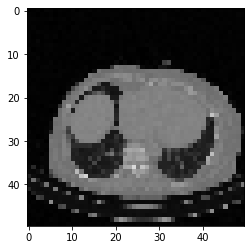

0


In [21]:
for i, l in train_dataset:
    print(i.shape)
    plt.imshow(i.transpose(1, 2).transpose(0, 2))
    plt.show()
    print(l)
    break

In [65]:
class ConvUnit(nn.Module):
    def __init__(self, in_f, out_f, ker=3, dropout=0.05, max_pull=False):
        super().__init__()
        if max_pull == False:
            self.net = nn.Sequential (
                nn.Conv2d(in_f, out_f, kernel_size=ker, padding=ker//2),
                nn.BatchNorm2d(out_f),
                nn.Dropout2d(dropout),
                nn.ReLU()
            )
        else:
            self.net = nn.Sequential (
                nn.Conv2d(in_f, out_f, kernel_size=ker, padding=ker//2, stride=2),
                nn.BatchNorm2d(out_f),
                nn.Dropout2d(dropout),
                nn.ReLU()
            )
    def forward(self, x):
        return self.net(x)

class FcUnit(nn.Module):
    def __init__(self, in_f, out_f, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential (
            nn.Linear(in_f, out_f),
            nn.BatchNorm1d(out_f),
            nn.Dropout(dropout),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)



class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ConvUnit(3, 16, ker=5, max_pull=True),
            ConvUnit(16, 32, ker=5, max_pull=True),

            nn.Flatten(),

            FcUnit(32 * 13 * 13, 250, dropout=0.5),
            FcUnit(250, 250, dropout=0.5),
            FcUnit(250, 3, dropout=0.)
        )

    def forward(self, x):
        return self.net(x)

In [66]:
a = nn.Sequential(
            ConvUnit(3, 32, ker=5),
            ConvUnit(32, 64, ker=5, max_pull=True),
            ConvUnit(64, 128, ker=3, max_pull=True),
            ConvUnit(128, 256, ker=3, max_pull=True),
)

a(th.randn(101, 3, 50, 50)).shape

torch.Size([101, 256, 7, 7])

In [67]:
net = Model().cuda()
criterion = nn.CrossEntropyLoss()

In [68]:
def opt_func(params, **kwargs):
    return OptimWrapper(optim.AdamW(params, **kwargs))

dls = DataLoaders(train_loader, validation_loader)

learn = Learner(dls, net, loss_func=criterion, cbs=[CudaCallback])

In [69]:
learn.fit_one_cycle(300)

epoch,train_loss,valid_loss,time
0,1.034785,1.059032,00:02
1,0.941186,1.045094,00:02
2,0.889015,1.045251,00:02
3,0.831843,1.031064,00:02
4,0.800693,1.027189,00:02
5,0.764900,1.016504,00:02
6,0.740282,1.012651,00:02
7,0.720802,1.015406,00:02
8,0.692431,1.016898,00:02
9,0.665594,1.005039,00:02


In [36]:
def train(model, train_loader, optimizer, epoch, criterion, l2_reg=1e-5):
    model.train()

    total_loss = []

    for data, target in tqdm(train_loader):
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()

        prediction = model(data)
        loss = criterion(prediction, target)

        s = 0
        for m in model.parameters():
            s += th.sum(m ** 2)

        loss += th.sqrt(s) * l2_reg

        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    avg_loss = sum(total_loss) / len(total_loss)
    print(f"Epoch: {epoch}:")
    print(f"Train Set: Average Loss: {avg_loss:.2f}")


def test(model, loader, criterion, dataset_name):
    model.eval()

    loss = 0
    correct = 0

    for data, target in tqdm(loader):
        with torch.no_grad():
            data = data.cuda()
            target = target.cuda()

            prediction = model(data)
            loss += criterion(prediction, target)

            correct += th.sum(prediction.argmax(dim=1) == target)

    loss /= len(loader.dataset)

    percentage_correct = 100.0 * correct / len(loader.dataset)

    print(
        dataset_name + ": {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(loader.dataset), percentage_correct
        ),
        flush=True
    )

    return loss.item(), percentage_correct.item()


In [37]:
ep = 0
# milestones = [10, 30, 50]
test_acc, train_acc = [], []
# optimizer = torch.optim.RMSprop(
#     filter(lambda p: p.requires_grad, net.parameters()), lr=1e-3, momentum=0.9, weight_decay=5e-4
# )
# scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer, milestones=milestones, gamma=0.1
# )

In [41]:
optimizer = torch.optim.Adam(
    net.parameters(), lr=1e-5
)
while True:
    ep += 1
    print(f"Training epoch #{ep}", flush=True)
    train(net, train_loader, optimizer, ep, criterion, l2_reg=0.)
    # scheduler.step()
    print("Accuracy:")
    train_acc.append(test(net, train_loader, criterion, "Train dataset"))
    test_acc.append(test(net, validation_loader, criterion, "Validation dataset"))

Training epoch #18
  0%|          | 0/235 [00:00<?, ?it/s]Epoch: 18:
Train Set: Average Loss: 0.49
Accuracy:
100%|██████████| 235/235 [00:02<00:00, 98.28it/s] Train dataset: 0.0054, Accuracy: 13152/15000 (87.68%)

100%|██████████| 71/71 [00:00<00:00, 104.91it/s]Validation dataset: 0.0108, Accuracy: 3206/4500 (71.24%)
Training epoch #19

  0%|          | 0/235 [00:00<?, ?it/s]Epoch: 19:
Train Set: Average Loss: 0.47
Accuracy:
100%|██████████| 235/235 [00:02<00:00, 94.50it/s]Train dataset: 0.0052, Accuracy: 13274/15000 (88.49%)

100%|██████████| 71/71 [00:00<00:00, 103.60it/s]Validation dataset: 0.0108, Accuracy: 3233/4500 (71.84%)
Training epoch #20

  0%|          | 0/235 [00:00<?, ?it/s]Epoch: 20:
Train Set: Average Loss: 0.47
Accuracy:
100%|██████████| 235/235 [00:02<00:00, 99.53it/s] Train dataset: 0.0051, Accuracy: 13300/15000 (88.67%)

100%|██████████| 71/71 [00:00<00:00, 100.77it/s]Validation dataset: 0.0105, Accuracy: 3265/4500 (72.56%)
Training epoch #21

  0%|          | 0/235

KeyboardInterrupt: 

In [39]:
test(net, train_loader, criterion, "Train")
test(net, validation_loader, criterion, "Validation")

100%|██████████| 235/235 [00:02<00:00, 100.02it/s]Train: 0.0062, Accuracy: 12515/15000 (83.43%)

100%|██████████| 71/71 [00:00<00:00, 91.41it/s]Validation: 0.0078, Accuracy: 3433/4500 (76.29%)



(0.0078255794942379, 76.28888702392578)

In [16]:
def ConfusionArrays(model, loader, criterion, dataset_name):
    model.eval()

    loss = 0
    correct = 0

    labels = []
    predictions = []

    for data, target in tqdm(loader):
        with torch.no_grad():
            data = data.cuda()
            target = target.cuda()

            prediction = model(data)
            
            for i in target:
                labels.append(i.item())
            for i in prediction:
                predictions.append(th.argmax(i).item())
    
    return labels, predictions
labels, predicted = ConfusionArrays(net, validation_loader, criterion, "Validation")

100%|██████████| 79/79 [00:00<00:00, 88.20it/s]


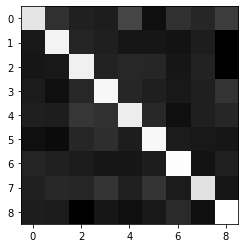

In [17]:
plt.imshow(np.sqrt(confusion_matrix(labels, predicted)), cmap='gray')

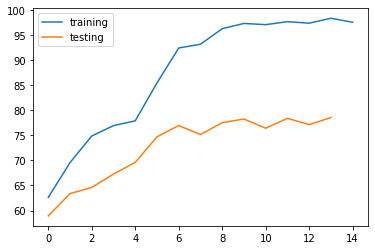

In [110]:
plt.plot([b for a, b in train_acc], label="training")
plt.plot([b for a, b in test_acc], label="testing")
plt.legend()
plt.show()

In [8]:
?th.load

Signature:
th.load(
    f,
    map_location=None,
    pickle_module=<module 'pickle' from '/home/theodor/anaconda3/lib/python3.8/pickle.py'>,
    **pickle_load_args,
)
Docstring:
Loads an object saved with :func:`torch.save` from a file.

:func:`torch.load` uses Python's unpickling facilities but treats storages,
which underlie tensors, specially. They are first deserialized on the
CPU and are then moved to the device they were saved from. If this fails
(e.g. because the run time system doesn't have certain devices), an exception
is raised. However, storages can be dynamically remapped to an alternative
set of devices using the :attr:`map_location` argument.

If :attr:`map_location` is a callable, it will be called once for each serialized
storage with two arguments: storage and location. The storage argument
will be the initial deserialization of the storage, residing on the CPU.
Each serialized storage has a location tag associated with it which
identifies the device it was saved fro

In [6]:
# Save / load model
# net = Model()
net = th.load("model.td")
# th.save(net, "model.td")

In [ ]:
# Generate test output.

with open("submission.txt", "w") as out_file:
    out_file.write("id,label\n")
    print("Generating submission: ")

    for id in range(len(test_dataset)):
        if id % 400 == 0:
            print(str(round(id / len(test_dataset) * 100)) + "%", end=" ")

        img = test_dataset[id]
        out = net(img.reshape(1, IMAGE_DIM, IMAGE_DIM))
        label = out.argmax(dim=1)[0]

        out_file.write(test_dataset.NameOfItem(id) + "," + str(label.item()) + "\n")
    
    print("Done!")


Generating submission: 
0% 8% 16% 24% 32% 40% 48% 56% 64% 72% 80% 88% 96% Done!


In [ ]:
class ModelTransfer(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = models.resnet18(pretrained=True)
        self.final_fc = nn.Linear(1000, 9)

    def forward(self, x):
        x = self.model(x)
        s = self.final_fc(x)

        return x

class Model1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            
            nn.MaxPool2d(2),
            
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            
            nn.MaxPool2d(2),
            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            
            nn.MaxPool2d(2),
            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Flatten(),
            
            nn.Dropout(0.15),
            nn.Linear(16 * 128, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.Linear(100, 9)    
        )

    def forward(self, x):
        x = self.model(x)

        return x

!wget https://github.com/theodormoroianu/AI/blob/master/dataset.zip\?raw=true > /dev/null 2> /dev/null
!unzip dataset.zip?raw=true > /dev/null

def deal_with_data(data_type: str):
    folder = data_type + "_folder"
    try:
        mkdir(folder)
        for i in range(9):
            mkdir(folder + "/" + str(i))
    except Exception:
        pass
    content = pd.read_csv(data_type + ".txt", header=None)
    for i in range(len(content)):
        name, label = content[0][i], content[1][i]
        copyfile(data_type + "/" + name, folder + "/" + str(label) + "/" + name)

deal_with_data("train")
deal_with_data("validation")

try:
    mkdir("test_folder")
    copytree("test", "test_folder/test")
except Exception:
    pass

In [4]:
def deal_with_data(data_type: str):
    folder = data_type + "_folder"
    try:
        mkdir(folder)
        for i in range(3):
            mkdir(folder + "/" + str(i))
    except Exception:
        pass
    content = pd.read_csv(data_type + ".txt", header=None)
    for i in range(len(content)):
        name, label = content[0][i], content[1][i]
        copyfile(data_type + "/" + name, folder + "/" + str(label) + "/" + name)

deal_with_data("train")
deal_with_data("validation")

try:
    mkdir("test_folder")
    copytree("test", "test_folder/test")
except Exception:
    pass